##  Contexto

El objetivo de este trabajo es realizar una prediccion de los kilogramos de mermelada que se pueden produccir teniendo en cuenta los insumos necesarios para su elaboración. La fuente de datos es tomada de un base de datos de una aplicación creada para el control de la produccion de la fabrica de conservas.

En este notebook se transita por todas las fases desde la exploracion de la data, limpieza, preparacion, entrenamiento del modelo y prueba de los algoritmos de Machine Learning.

### Librerías

In [10]:
#!pip3 install tabulate

In [11]:
#!pip3 install optuna

In [12]:
#!pip3 install fitter


In [13]:
#!pip3 install tqdm

In [14]:
#from tqdm.autonotebook import tqdm as notebook_tqdm

In [15]:
#!pip3 install nbconvert


In [16]:
!pip3 install nbconvert[qtpdf]


In [17]:
#!pip3 install seaborn

In [18]:
#!pip3 install statsmodels


In [19]:
#!pip3 install scikit-learn


In [20]:
#!pip3 install scikit-optimize


### Enmarcar el problema

El hecho de no poder tener una visión de cuantas conservas se pueden elaborar con el 'stock' de insumos y materias primas con que se cuenta, o viceversa, por no saber de ante mano cuanta materia prima se necesita para elaborar una cierta cantidad de dulce de conservas (mermelada), genera un problema de control y planificacion de las compras de insumos y las ventas a los clientes, ya que no se pueden hacer los envíos a los pedidos de estos por no tener la certeza  de cumplir con los compromisos.

Dado esta situacion se decidió estudiar los datos historico de un período almacenados en una base de datos de todas las produciones de un periodo de XXXX años, desde el año XXX hasta el año XXX

## Tratamiento de datos

In [2]:
# ==============================================================================
import numpy as np
import pandas as pd
from tabulate import tabulate

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.api as sm

# Preprocesado y modelado
# ==============================================================================
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge

from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence
import optuna

# Varios
# ==============================================================================
import multiprocessing
import random
from itertools import product
from fitter import Fitter, get_common_distributions

**Configuración Matplotlib**

In [3]:
# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

### Obtener los Datos

In [2]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

data=pd.read_csv("Archivos/industria.csv")


Vamos a empezar por fijarnos en las cinco filas superiores de los datos utilizando el método  head() de DataFrame. 

In [3]:
data.head(7)

,fecha,producto,codigo_producto,kg-fruta,kg-mermelada,agua,E-electrica,combustible,azucar,cant-conserv,devol,precio,ingreso,costo,utilidad,N-dulc,area
0,5/2/2012 15:56,Mermelada de Papaya Lata 3.2kg,P32,8394.849343,5899.714318,2.418383244,120.338210,114.254195,4028.278186,594.187361,46,18.45,10114.056810,1021.782359,10068.477500,4,21000
1,4/21/2016 18:41,Mermelada de Guayaba Lata 3.2kg,G32,2987.830552,3244.635687,1.093655339,385.518987,65.552602,1954.357174,433.546984,8,19.50,8298.166195,180.416295,6032.987521,5,21000
2,7/24/2020 16:44,Mermelada de Papaya Lata 3.2kg,P32,924.516591,1067.128567,7.36403412,119.256494,54.435449,640.264597,359.444475,8,18.45,6484.150564,158.268635,5262.253422,4,21000
3,1/15/2010 22:44,Mermelada de Guayaba Lata 3.2kg,G32,2038.123800,2089.481910,6.668539393,219.504071,68.928403,573.340398,521.167065,13,19.50,9909.257774,150.530752,7866.385626,5,21000
4,6/6/2019 8:09,Mermelada de Guayaba Lata 3.2kg,G32,1049.965138,1325.824440,7.963602721,151.588832,79.276929,703.751300,653.532697,5,19.50,12646.387580,276.920241,9179.856338,5,21000
5,3/8/2019 10:44,Mermelada de Guayaba Lata 3.2kg,G32,3379.987777,3604.045399,1.279704603,212.006768,65.041274,1345.971768,720.524260,82,19.50,12451.223060,778.971329,11005.990540,3,21000
6,3/22/2010 22:40,Mermelada de Guayaba Lata 3.2kg,G32,6054.785239,4970.865848,NaN,222.395189,166.461296,4196.907440,980.530090,179,19.50,15629.836760,1135.630406,13942.724420,3,21000


El método info() es útil para obtener una descripción rápida de los datos, en particular el  número total de filas, el tipo de cada atributo y el número de valores no nulos:

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14275 entries, 0 to 14274
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   fecha            14275 non-null  object 
 1   producto         14275 non-null  object 
 2   codigo_producto  14275 non-null  object 
 3   kg-fruta         14275 non-null  float64
 4   kg-mermelada     14275 non-null  float64
 5   agua             14238 non-null  object 
 6   E-electrica      14275 non-null  float64
 7   combustible      14275 non-null  float64
 8   azucar           14275 non-null  float64
 9   cant-conserv     14275 non-null  float64
 10  devol            14275 non-null  int64  
 11  precio           14275 non-null  float64
 12  ingreso          14275 non-null  float64
 13  costo            14275 non-null  float64
 14  utilidad         14275 non-null  float64
 15  N-dulc           14275 non-null  int64  
 16  area             14275 non-null  int64  
dtypes: float64(1

### Conversión de tipo

In [6]:
# Convirtiendo fecha a 'datetime'
data['fecha'] = pd.to_datetime(data['fecha'], errors='coerce')


# Convirtiendo 'agua' a 'numerico'
# Reemplazar los espacios en blanco por NaN
data['agua'] = pd.to_numeric(data['agua'].str.strip(), errors='coerce', downcast='float')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14275 entries, 0 to 14274
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   fecha            14275 non-null  datetime64[ns]
 1   producto         14275 non-null  object        
 2   codigo_producto  14275 non-null  object        
 3   kg-fruta         14275 non-null  float64       
 4   kg-mermelada     14275 non-null  float64       
 5   agua             14231 non-null  float32       
 6   E-electrica      14275 non-null  float64       
 7   combustible      14275 non-null  float64       
 8   azucar           14275 non-null  float64       
 9   cant-conserv     14275 non-null  float64       
 10  devol            14275 non-null  int64         
 11  precio           14275 non-null  float64       
 12  ingreso          14275 non-null  float64       
 13  costo            14275 non-null  float64       
 14  utilidad         14275 non-null  float

Vamos a echar un vistazo a los otros campos. El método describe() muestra un resumen  de los atributos numéricos. 

In [8]:
data.describe()

,fecha,kg-fruta,kg-mermelada,agua,E-electrica,combustible,azucar,cant-conserv,devol,precio,ingreso,costo,utilidad,N-dulc,area
count,14275,14275.000000,14275.000000,14231.000000,14275.000000,14275.000000,14275.000000,14275.000000,14275.000000,14275.000000,14275.000000,14275.000000,14275.000000,14275.000000,14275.0
mean,2014-01-06 03:42:04.493169920,2926.787562,2683.280972,2.969593,291.865943,88.463111,1439.636079,621.248795,39.327986,18.974448,11079.168833,522.833005,10500.913742,4.495832,21000.0
min,2006-01-01 10:22:00,400.391488,849.591374,0.000000,110.032829,25.093843,92.662434,203.681106,0.000000,18.450000,3689.959272,94.734802,2938.774632,3.000000,21000.0
25%,2010-01-17 22:13:30,1574.207487,1800.874507,1.116445,202.057538,63.124019,675.002464,446.384749,6.000000,18.450000,8007.254107,172.020290,6887.489718,3.000000,21000.0
50%,2014-01-06 02:42:00,2459.316861,2391.123026,2.056236,278.927255,82.885476,1146.034468,586.162457,14.000000,18.450000,10495.441950,519.668583,9517.459873,4.000000,21000.0
75%,2017-12-31 03:18:30,3882.719831,3296.462237,4.203520,380.021907,108.779106,1899.839002,762.988440,65.000000,19.500000,13497.986235,866.882754,13161.660930,5.000000,21000.0
max,2021-12-30 17:10:00,9902.132950,8403.649035,13.565312,499.941487,214.863636,7380.944962,1427.482283,261.000000,19.500000,27738.404530,1215.662107,26073.118990,6.000000,21000.0
std,NaN,1796.703766,1203.050396,2.557498,106.910537,33.626824,1059.616979,229.344619,47.456586,0.525018,4002.576651,373.864486,4661.437112,1.117156,0.0


#### Calculando el Porciento de Devoluciones

In [9]:
pdevol = data['devol'].sum()/data['cant-conserv'].sum()*100
print(f"Porciento de devoluciones = {pdevol.round(0)} %")

Porciento de devoluciones = 6.0 %


#### Ajuste los decimales del describe a solo dos dígitos

In [176]:
data=data.round(2)
data

,fecha,producto,codigo_producto,kg-fruta,kg-mermelada,agua,E-electrica,combustible,azucar,cant-conserv,devol,precio,ingreso,costo,utilidad,N-dulc,area
0,2012-05-02 15:56:00,Mermelada de Papaya Lata 3.2kg,P32,8394.85,5899.71,2.42,120.34,114.25,4028.28,594.19,46,18.45,10114.06,1021.78,10068.48,4,21000
1,2016-04-21 18:41:00,Mermelada de Guayaba Lata 3.2kg,G32,2987.83,3244.64,1.09,385.52,65.55,1954.36,433.55,8,19.50,8298.17,180.42,6032.99,5,21000
2,2020-07-24 16:44:00,Mermelada de Papaya Lata 3.2kg,P32,924.52,1067.13,7.36,119.26,54.44,640.26,359.44,8,18.45,6484.15,158.27,5262.25,4,21000
3,2010-01-15 22:44:00,Mermelada de Guayaba Lata 3.2kg,G32,2038.12,2089.48,6.67,219.50,68.93,573.34,521.17,13,19.50,9909.26,150.53,7866.39,5,21000
4,2019-06-06 08:09:00,Mermelada de Guayaba Lata 3.2kg,G32,1049.97,1325.82,7.96,151.59,79.28,703.75,653.53,5,19.50,12646.39,276.92,9179.86,5,21000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14270,2014-07-31 10:05:00,Mermelada de Guayaba Lata 3.2kg,G32,3243.15,2255.86,11.51,429.98,77.64,851.81,865.83,4,19.50,16805.76,262.57,13260.26,6,21000
14271,2014-10-11 19:44:00,Mermelada de Guayaba Lata 3.2kg,G32,1608.31,1773.27,3.81,224.12,99.47,512.61,681.97,0,19.50,13298.49,213.22,10438.77,5,21000
14272,2021-02-10 12:00:00,Mermelada de Papaya Lata 3.2kg,P32,2803.20,3109.65,7.27,285.25,74.26,757.18,419.43,0,18.45,7738.50,161.44,6550.04,6,21000
14273,2012-12-29 13:55:00,Mermelada de Guayaba Lata 3.2kg,G32,2425.70,1884.47,2.10,306.88,64.55,1037.53,418.70,6,19.50,8047.74,139.96,6196.37,5,21000


### Detectando valores nulos

In [7]:
data.isnull().sum()

fecha               0
producto            0
codigo_producto     0
kg-fruta            0
kg-mermelada        0
agua               44
E-electrica         0
combustible         0
azucar              0
cant-conserv        0
devol               0
precio              0
ingreso             0
costo               0
utilidad            0
N-dulc              0
area                0
dtype: int64

#### Analizando los histogramas

Otra manera rápida de hacerse una idea del tipo de datos que estamos manejando es trazar  un histograma para cada atributo numérico. Un histograma muestra el número de instancias (en  el eje vertical) que tienen un rango de valores dado (en el eje horizontal). Podemos trazar esto  de atributo en atributo o podemos llamar al método hist() en el conjunto de datos completo  (como se muestra en el siguiente ejemplo de código) y eso trazará un histograma para cada  atributo numérico. . 

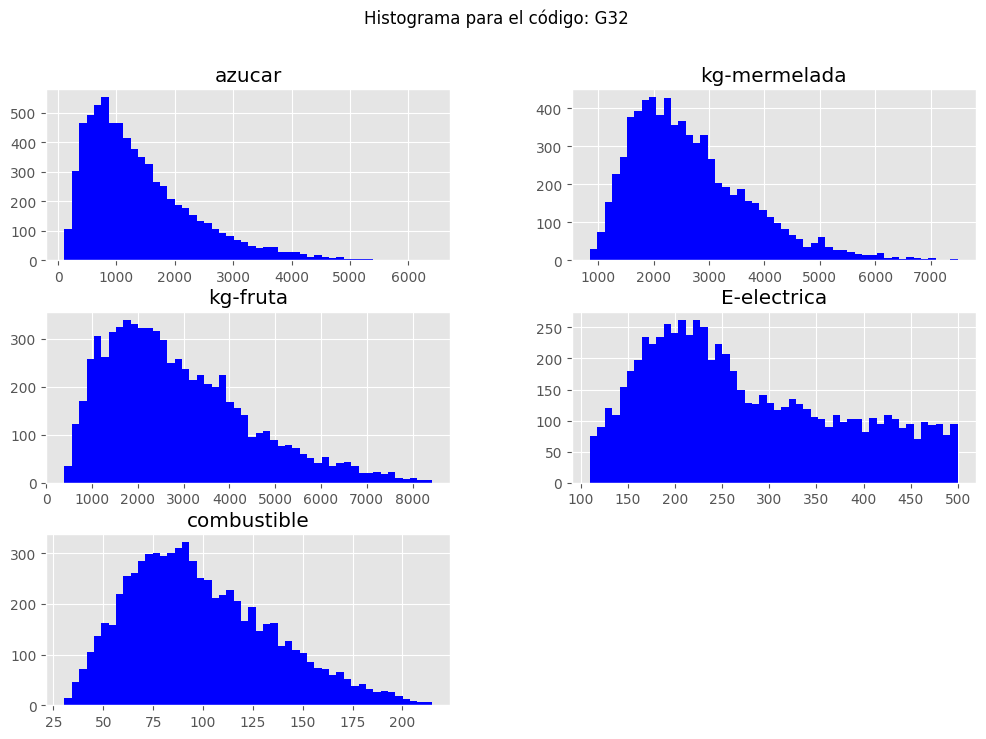

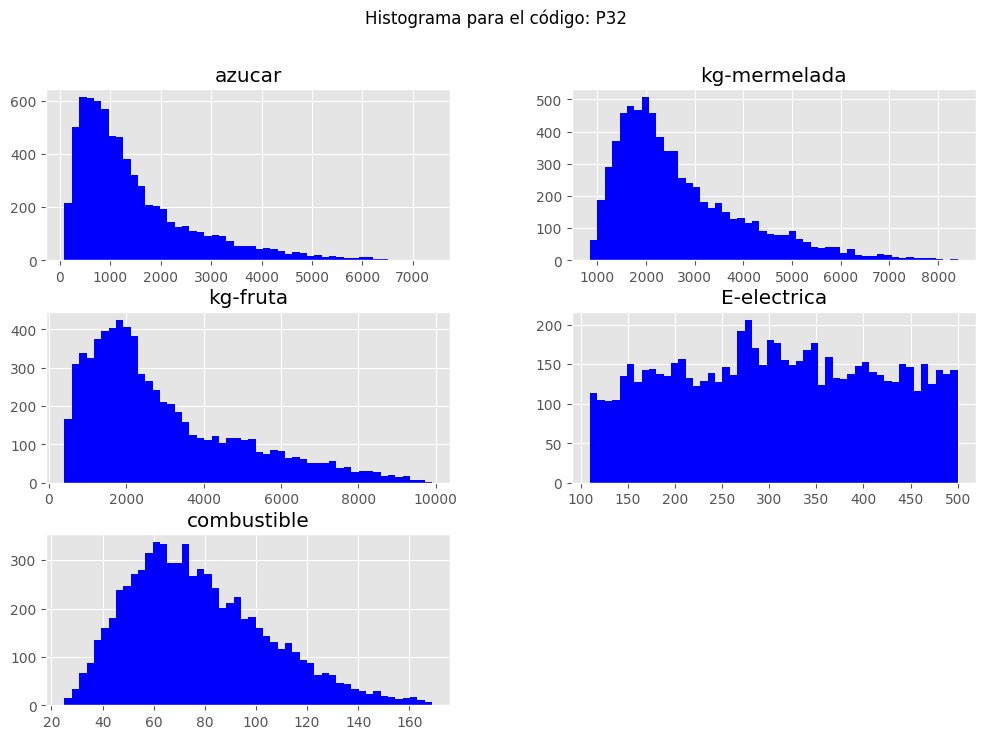

In [11]:
import matplotlib.pyplot as plt

columnas_a_mostrar = ['azucar', 'kg-mermelada', 'kg-fruta', 'E-electrica', 'combustible']
for codigo, grupo in data.groupby('codigo_producto'):
    # Filtrar el grupo para solo incluir las columnas deseadas
    grupo_filtrado = grupo[columnas_a_mostrar]

    # Crear un histograma para cada grupo por código
    grupo_filtrado.hist(bins=50, figsize=(12, 8), color='blue')
    
    # Añadir título al gráfico
    plt.suptitle(f'Histograma para el código: {codigo}')
    
    # Mostrar el gráfico
    plt.show()


Por último, muchos histogramas están sesgados a la derecha: se extienden mucho más  hacia la derecha de la mediana que hacia la izquierda. Esto puede dificultar un poco la  detección de patrones por parte de algunos algoritmos de machine learning. Probaremos  a transformar estos atributos más adelante para tener distribuciones más simétricas  y con forma más acampanada.

Como se puede observar en nuestro caso hay un sesgo importante hacia la derecha  denotando una mayor fecuencia de valores mas bajos a la izquierda de la mediana.

### Creando los conjuntos de prueba y entrenamiento.

Si se calcula el error de generalización utilizando el conjunto de prueba, la  estimación será demasiado optimista y lanzarás un sistema que no tendrá un rendimiento tan  bueno como se esperaba.  
Esto se llama sesgo de "espionaje de datos".  En teoría, crear un conjunto de prueba es simple; elige algunas instancias de forma aleatoria, por lo general el 20% del conjunto de datos (o menos, si el conjunto es muy grande) y  déjalas aparte:

In [21]:
import numpy as np

random_seed = 42

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [22]:
train_set, test_set = shuffle_and_split_data(data, 0.2)
len(train_set)

11420

In [283]:
len(test_set)

2855

## Explorar y visualizar los datos para tener un mayor entendimiento.  

Hasta ahora, solo has echado un vistazo rápido a los datos para entender a nivel general  qué tipos de datos estás manipulando.  

En primer lugar, hay que asegurarse que se ha apartado el conjunto de prueba y solo se está explorando el conjunto de entrenamiento. Además, si el conjunto de entrenamiento es muy grande,  puede que quieras crear un conjunto de exploración para hacer que la manipulación sea más  rápida y sencilla durante la fase de exploración. En este caso, el conjunto de entrenamiento es  bastante pequeño, así que podemos trabajar directamente en el conjunto completo. Puesto que  vamos a experimentar con varias transformaciones del conjunto de entrenamiento completo,  deberíamos hacer una copia del original para poder revertir a él después: . 

In [24]:
data = train_set.copy() 

### Buscar correlaciones.    
Puesto que el conjunto de datos no es demasiado grande, puedes calcular con facilidad el  coeficiente de correlación estándar (también llamado coeficiente r de Pearson) entre cada par  de atributos utilizando el método `corr()`:. 

Primero veamos las correlaciones de los distintos atributos de la 'data', para asegurranos que varaibles pueden ser de interés en el estudio.

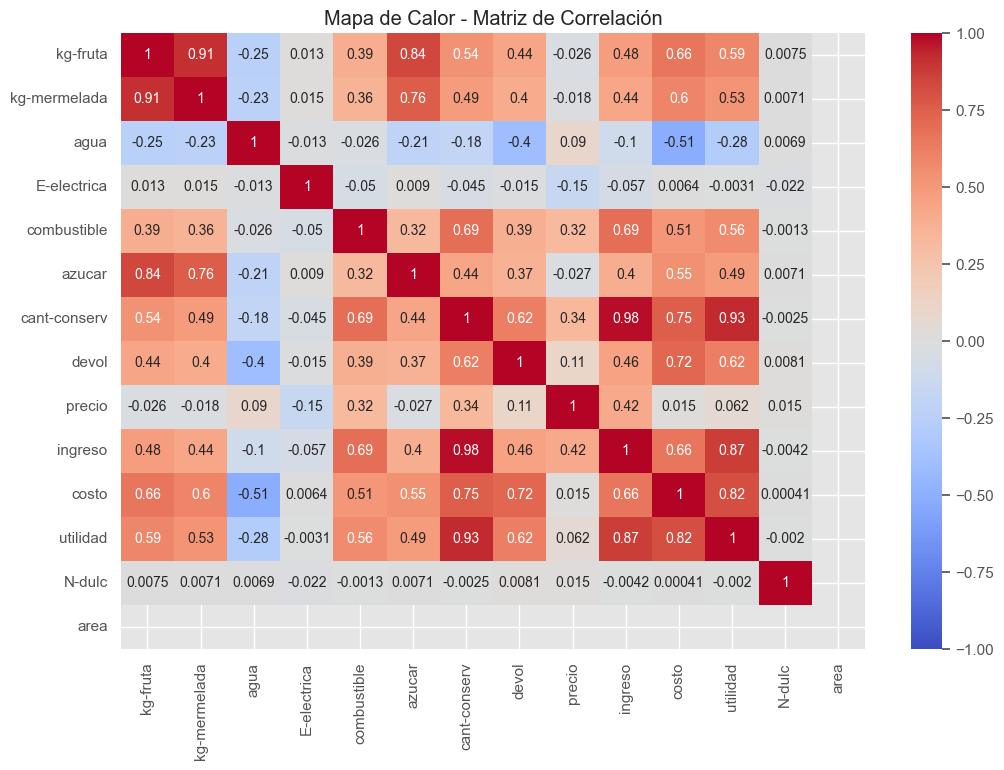

In [183]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Suponiendo que 'data' es tu DataFrame original
# Calcular la matriz de correlación
corr_matrix = data.corr(numeric_only=True)

# Crear el mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Añadir el título
plt.title('Mapa de Calor - Matriz de Correlación')
plt.show()


Podemos ver como se correlacionan las variables numericas con 'kilogramos de guayaba producidos'

In [184]:

import pandas as pd

# Supongamos que 'data' es tu DataFrame original

# Selecciona solo las columnas numéricas
numeric_data = data.select_dtypes(include='number')

# Ahora calcula la correlación solo con las columnas numéricas
correlation_with_atributo = numeric_data.corr()['kg-mermelada']

# Mostrar las correlaciones
print(correlation_with_atributo)


kg-fruta        0.908240
kg-mermelada    1.000000
agua           -0.226750
E-electrica     0.015191
combustible     0.360702
azucar          0.762757
cant-conserv    0.485147
devol           0.401279
precio         -0.018321
ingreso         0.435269
costo           0.596785
utilidad        0.529655
N-dulc          0.007058
area                 NaN
Name: kg-mermelada, dtype: float64


In [185]:
print(data['area'].dtype)

int64


### Extraemos las variables de interes en el estudio

In [285]:
col_de_interes = ['kg-fruta', 'azucar', 'combustible', 'E-electrica', 'kg-mermelada']

corr_matrix = data[col_de_interes].corr(numeric_only=True)
print(col_de_interes)


['kg-fruta', 'azucar', 'combustible', 'E-electrica', 'kg-mermelada']


### Calculando la matriz de correlación de las 'caracteristicas' con la variable objjetivo 'kg-mermelada'

In [187]:
# Calcular la matriz de correlación solo para las columnas de interés
corr_matrix = data[col_de_interes].corr()

# Seleccionar las correlaciones de 'kg-mermelada' con las otras columnas y ordenarlas
kg_mermelada_corr = corr_matrix['kg-mermelada'].loc[['kg-fruta', 'azucar', 'combustible', 'E-electrica']].sort_values(ascending=False)

# Mostrar las correlaciones ordenadas
print(kg_mermelada_corr)



kg-fruta       0.908240
azucar         0.762757
combustible    0.360702
E-electrica    0.015191
Name: kg-mermelada, dtype: float64


Ahora puedes fijarte en cuánto se correlaciona cada atributo con el valor de los 'kg de mermelada producidos': 

### Mapa de calor de las correlaciones

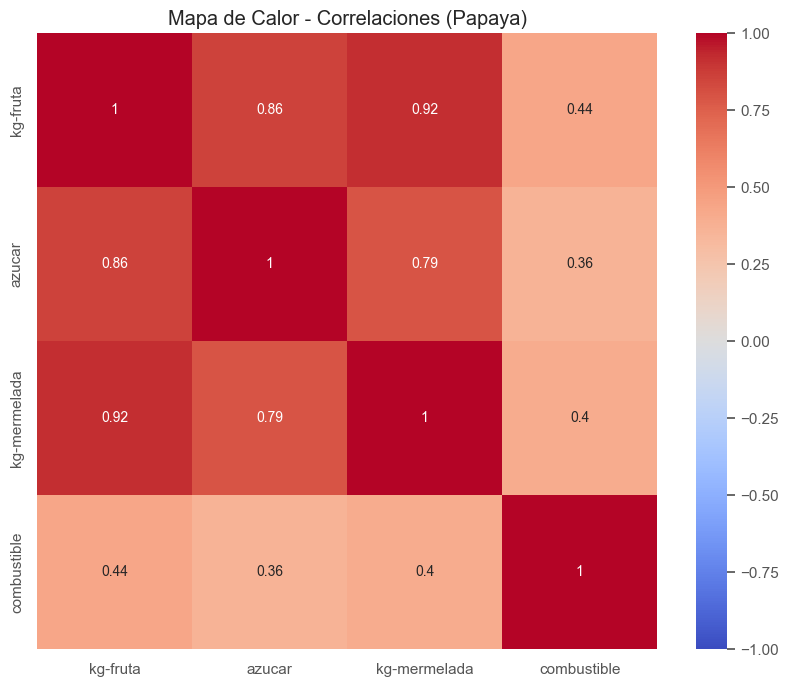

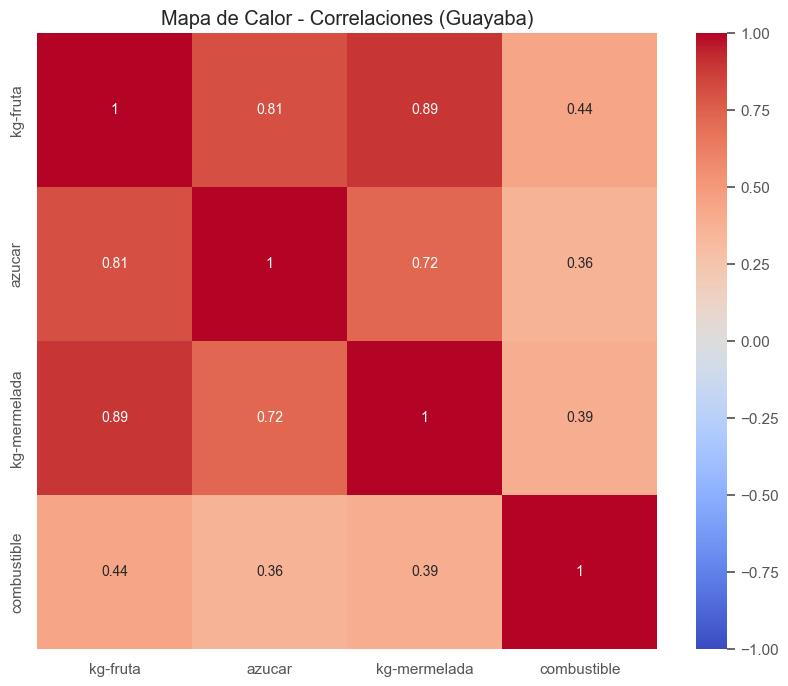

In [188]:
# Filtrar los datos por codigo_producto
data_papaya = data.loc[data['codigo_producto'] == 'P32']
data_guayaba = data.loc[data['codigo_producto'] == 'G32']

# Seleccionar las columnas relevantes para Papaya
col_de_interes_papaya = ['kg-fruta', 'azucar', 'kg-mermelada', 'combustible']
correlation_matrix_papaya = data_papaya[col_de_interes_papaya].corr()

# Crear el mapa de calor para Papaya
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_papaya, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Mapa de Calor - Correlaciones (Papaya)')
plt.show()

# Seleccionar las columnas relevantes para Guayaba
col_de_interes_guayaba = ['kg-fruta', 'azucar', 'kg-mermelada', 'combustible']
correlation_matrix_guayaba = data_guayaba[col_de_interes_guayaba].corr()

# Crear el mapa de calor para Guayaba
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_guayaba, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Mapa de Calor - Correlaciones (Guayaba)')
plt.show()


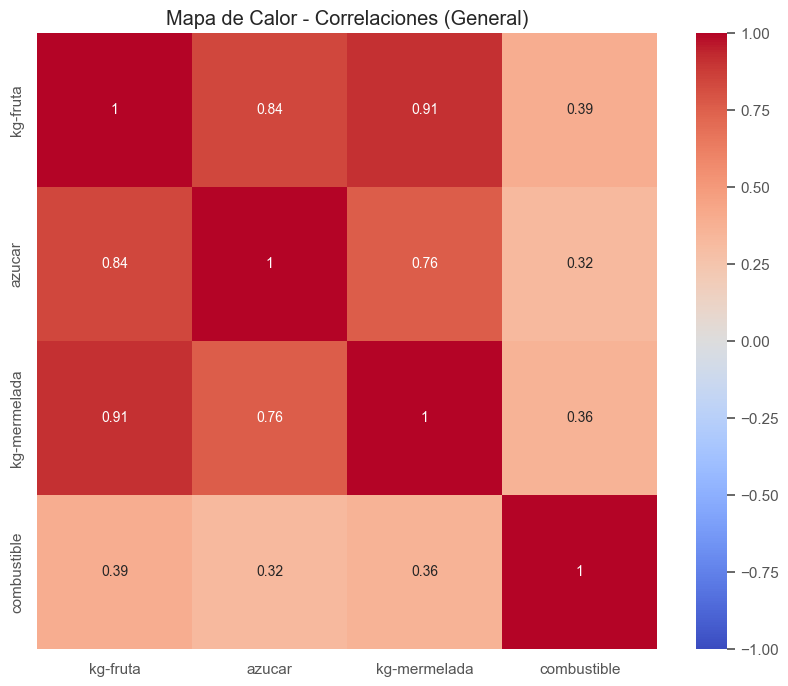

In [189]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar las columnas relevantes para la correlación
col_de_interes = ['kg-fruta', 'azucar', 'kg-mermelada', 'combustible']

# Calcular la matriz de correlación para todo el DataFrame
correlation_matrix = data[col_de_interes].corr()

# Crear el mapa de calor para todas las frutas
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Mapa de Calor - Correlaciones (General)')
plt.show()


Podemos observar que los atributos mas prometedor para predecir la cantidad de mermelada ('kg-mermelada') a producir son: 'kg-fruta' y 'azucar'

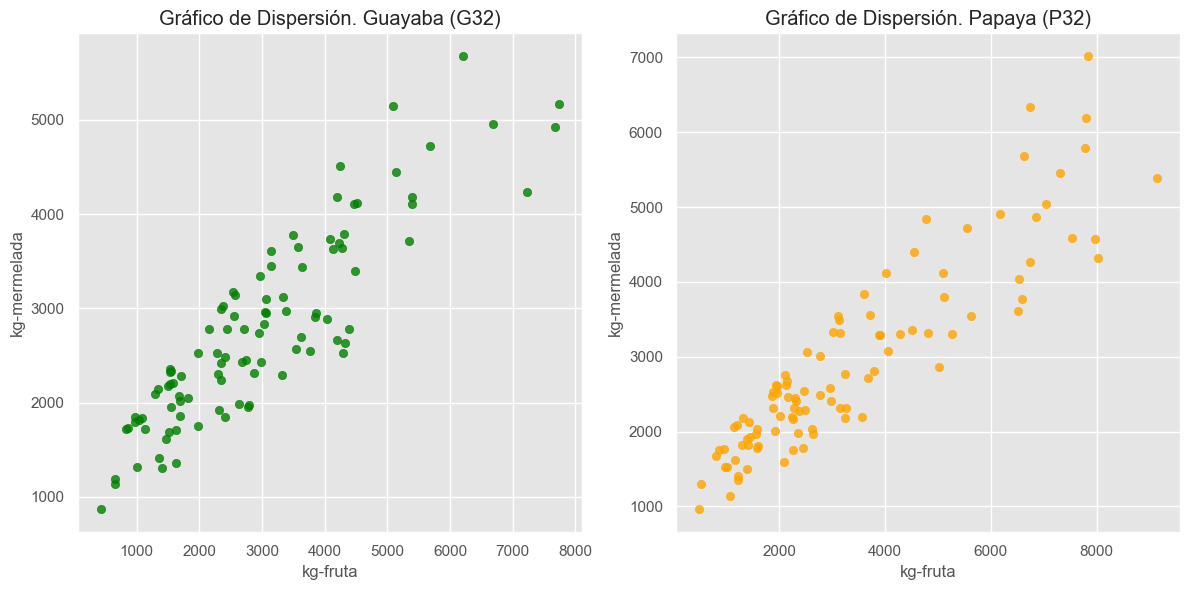

In [190]:
import pandas as pd
import matplotlib.pyplot as plt

# Suponiendo que 'data' es tu DataFrame original
# Filtrar los datos por cada categoría y tomar una muestra aleatoria de 100
guayaba_data = data[data['codigo_producto'] == 'G32'].sample(n=100, random_state=1)
papaya_data = data[data['codigo_producto'] == 'P32'].sample(n=100, random_state=1)

# Crear el gráfico
plt.figure(figsize=(12, 6))

# Gráfico para Guayaba (G32)
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.scatter(guayaba_data['kg-fruta'], guayaba_data['kg-mermelada'],
            alpha=0.8, color='green')  # Aumentar visibilidad
plt.title('Gráfico de Dispersión. Guayaba (G32)')
plt.xlabel('kg-fruta')
plt.ylabel('kg-mermelada')
plt.grid(True)

# Gráfico para Papaya (P32)
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.scatter(papaya_data['kg-fruta'], papaya_data['kg-mermelada'],
            alpha=0.8, color='orange')  # Aumentar visibilidad
plt.title('Gráfico de Dispersión. Papaya (P32)')
plt.xlabel('kg-fruta')
plt.ylabel('kg-mermelada')
plt.grid(True)

# Ajustar el diseño
plt.tight_layout()
# Mostrar el gráfico
plt.show()


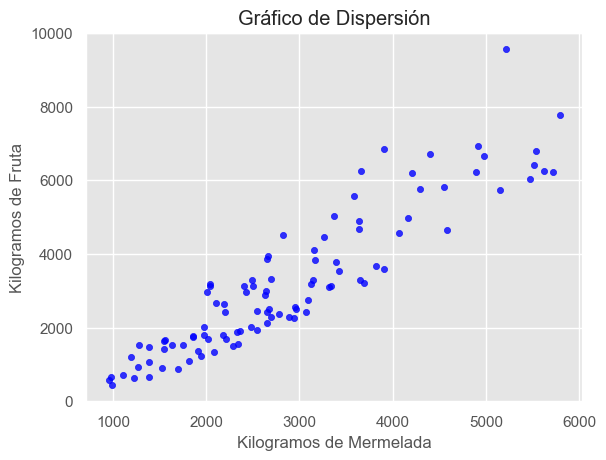

In [191]:
# Tomar una muestra aleatoria de 100 datos
sample_data = data.sample(n=100, random_state=1)

# Crear el gráfico de dispersión con puntos más visibles
sample_data.plot(kind="scatter", x="kg-mermelada", y="kg-fruta", 
                 alpha=0.8, color='blue', grid=True)  # Ajustar alpha y color
plt.title('Gráfico de Dispersión')
plt.xlabel('Kilogramos de Mermelada')
plt.ylabel('Kilogramos de Fruta')
plt.show()


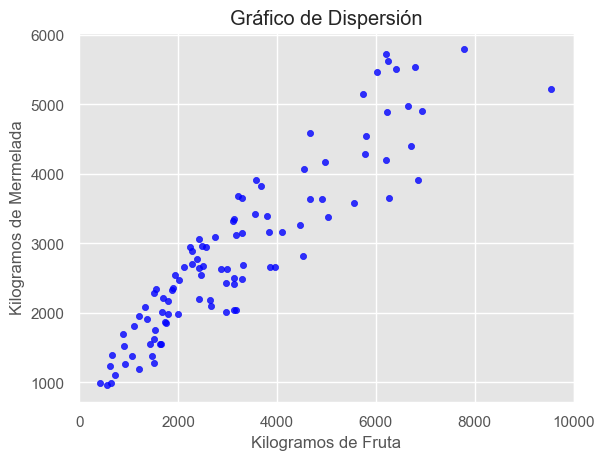

In [192]:
# Tomar una muestra aleatoria de 100 datos
sample_data = data.sample(n=100, random_state=1)

# Crear el gráfico de dispersión con puntos más visibles
sample_data.plot(kind="scatter", x="kg-fruta", y="kg-mermelada", 
                 alpha=0.8, color='blue', grid=True)  # Ajustar alpha y color
plt.title('Gráfico de Dispersión')
plt.xlabel('Kilogramos de Fruta')
plt.ylabel('Kilogramos de Mermelada')
plt.show()

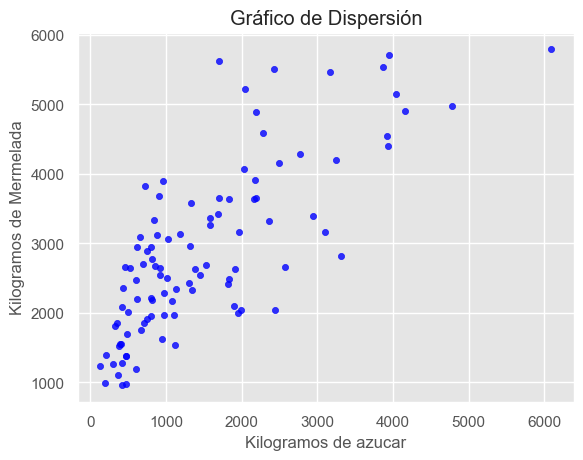

In [193]:
# Tomar una muestra aleatoria de 100 datos
sample_data = data.sample(n=100, random_state=1)

# Crear el gráfico de dispersión con puntos más visibles
sample_data.plot(kind="scatter", x="azucar", y="kg-mermelada", 
                 alpha=0.8, color='blue', grid=True)  # Ajustar alpha y color
plt.title('Gráfico de Dispersión')
plt.xlabel('Kilogramos de azucar')
plt.ylabel('Kilogramos de Mermelada')
plt.show()


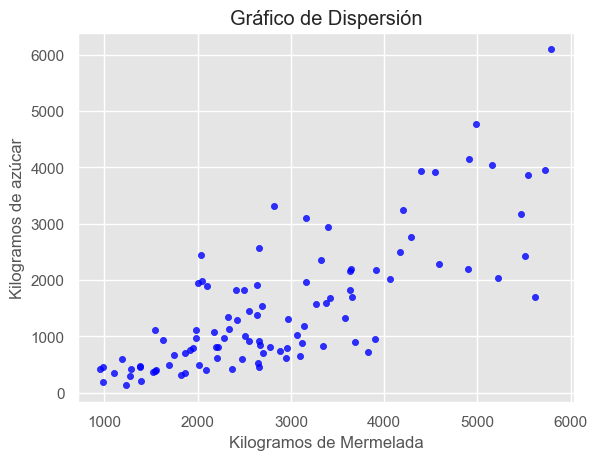

In [194]:
# Tomar una muestra aleatoria de 100 datos
sample_data = data.sample(n=100, random_state=1)

# Crear el gráfico de dispersión con puntos más visibles
sample_data.plot(kind="scatter", x="kg-mermelada", y="azucar", 
                 alpha=0.8, color='blue', grid=True)  # Ajustar alpha y color
plt.title('Gráfico de Dispersión')
plt.xlabel('Kilogramos de Mermelada')
plt.ylabel('Kilogramos de azúcar')
plt.show()


Y ahora vamos a volver a fijarnos en la matriz de correlaciones:. 

In [196]:
corr_matrix = data.corr(numeric_only=True)
corr_matrix["kg-mermelada"].sort_values(ascending=False)

kg-mermelada    1.000000
kg-fruta        0.908240
azucar          0.762757
costo           0.596785
utilidad        0.529655
cant-conserv    0.485147
ingreso         0.435269
devol           0.401279
combustible     0.360702
E-electrica     0.015191
N-dulc          0.007058
precio         -0.018321
agua           -0.226750
area                 NaN
Name: kg-mermelada, dtype: float64

## Preparar los datos para algoritmos de machine learning.  

En el momento de preparar los datos para tus algoritmos de machine learning. En vez de  hacerlo a mano, se pordrían escribir funciones para este fin, por varias razones:   

-  Te permitirá reproducir estas transformaciones con facilidad en cualquier conjunto de  datos (por ejemplo, la próxima vez que consigas un conjunto de datos nuevo).  
-  Poco a poco irás creando una biblioteca de funciones de transformación que podrás  reutilizar en futuros proyectos.
-  Puedes utilizar estas funciones en tu sistema online para transformar los datos nuevos  antes de introducirlos en los algoritmos.
-  Podrás probar con facilidad varias transformaciones y ver qué combinación de transformaciones funciona mejor.

Primero, vamos a volver a un conjunto de entrenamiento limpio (mas bien original o sin manipular) (copiando otra vez  strat_train_set). También deberíamos separar los predictores y las etiquetas (target), puesto que no  tenemos por qué querer aplicar las mismas transformaciones a los predictores y los valores  objetivo (fíjate en que drop() crea una copia de los datos y no afecta a strat_train_set):

In [25]:
data = train_set.drop("kg-mermelada", axis=1)
data_labels = train_set["kg-mermelada"].copy()

### Limpiar datos

La mayoría de los algoritmos de machine learning no pueden funcionar si faltan características, así que necesitamos ocuparnos de ello.   

1. Deshacernos de las filas de haber NaN en las columnas.
2. Deshacernos de todo el atributo (Eliminar la columna).
3. Establecer algún valor para esos valores que faltan (cero, la media, la mediana, etc.).  Esto se denomina "imputación". . 

Esto puede hacerse con facilidad utilizando los métodos dropna(), drop() y fillna() de  DataFrame de Pandas: 

### Mostrando los datos nulos NaN

In [12]:
null_rows_idx = data.isnull().any(axis=1) # Quiero ver los NaN
data.loc[null_rows_idx].head(10)

,fecha,producto,codigo_producto,kg-fruta,agua,E-electrica,combustible,azucar,cant-conserv,devol,precio,ingreso,costo,utilidad,N-dulc,area
704,2018-11-08 18:50:00,Mermelada de Papaya Lata 3.2kg,P32,1842.323057,NaN,213.464110,100.206017,847.533196,428.045208,12,18.45,7676.034090,167.676419,6433.051514,5,21000
621,2012-06-29 23:33:00,Mermelada de Papaya Lata 3.2kg,P32,1462.450257,NaN,337.450604,66.664999,1039.048152,446.741428,35,18.45,7596.629349,550.740832,9741.750784,4,21000
102,2013-01-11 23:25:00,Mermelada de Papaya Lata 3.2kg,P32,1560.275594,NaN,267.400717,49.204241,630.706928,328.172166,6,18.45,5944.076467,116.838280,5095.085803,3,21000
97,2009-06-03 08:37:00,Mermelada de Papaya Lata 3.2kg,P32,1795.787194,NaN,288.999087,80.684500,463.123045,500.189458,31,18.45,8656.545491,727.416176,9844.296608,3,21000
96,2018-07-24 12:01:00,Mermelada de Guayaba Lata 3.2kg,G32,1060.158663,NaN,117.720768,56.063082,790.851530,392.213522,7,19.50,7511.663683,146.862988,5638.463076,5,21000
370,2019-09-28 12:48:00,Mermelada de Guayaba Lata 3.2kg,G32,3770.644229,NaN,135.441371,99.121069,2444.615028,645.292918,78,19.50,11062.211910,737.715066,9437.070953,5,21000
702,2008-06-24 19:29:00,Mermelada de Guayaba Lata 3.2kg,G32,1385.247967,NaN,150.773731,63.122690,619.433663,528.483721,95,19.50,8452.932564,643.971347,7201.763873,5,21000
103,2019-04-29 15:13:00,Mermelada de Guayaba Lata 3.2kg,G32,2448.865053,NaN,118.041751,96.515278,716.474360,737.209252,60,19.50,13205.580410,738.347848,11945.965950,3,21000
167,2009-05-13 22:14:00,Mermelada de Papaya Lata 3.2kg,P32,811.373310,NaN,152.681733,35.109217,217.283023,271.141980,4,18.45,4928.769540,123.140312,3960.842262,4,21000
106,2016-06-01 20:41:00,Mermelada de Guayaba Lata 3.2kg,G32,1735.254913,NaN,118.076351,120.458657,945.210836,1186.762788,137,19.50,20470.374360,1142.216073,19528.538450,3,21000


#### Calculando la dispersión relativa en el atributo 'agua' 

In [13]:
#Calculando la dispersion de el atributo `agua`
data['agua'] = pd.to_numeric(data['agua'], errors='coerce')
Cv_agua= data['agua'].std()/data['agua'].mean()*100
Cv_agua

86.30446365544489

* El atributo 'agua' en la 'data' hace referencia a la cantidad de agua consumida en la fabrica, donde su mayor consumo es en la limpieza y como se puede observar en el *`Cv`* (Coeficiente de variación), existe una dispersión muy alta alrdedor de la media (muy natural en fabricas de conservas). Con este valor y teniendo en cuenta el objetivo principal de nuestro modelo, decidimos que podemos rescindir de la columna 'agua' en el modelo.

* La columna 'area' representa el área en metros cuadrados de la fabrica, es un valor constante que se mantiene inalterable a lo largo de todas las filas, también podemos prescindir de el atributo 'area'

* La columna 'N-dulc' es un dato entero del número de dulcero que participa en la fabricación de la conserva; teniendo en cuenta nuestras expectativas en este proyecto, tambié prescindimos de 'N-dulc'

#### Eliminando atributos 'agua', 'area' y 'N-dulc'

In [26]:
data = data.drop(columns=['agua', 'area', 'N-dulc'])

### Busqueda de Outliers

In [27]:
from sklearn.ensemble import IsolationForest

X = data[['kg-fruta', 'azucar']]

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)

In [28]:
outlier_pred

array([1, 1, 1, ..., 1, 1, 1])

-1 Outlier  
1 No es outlier

#### Graficando los outliers

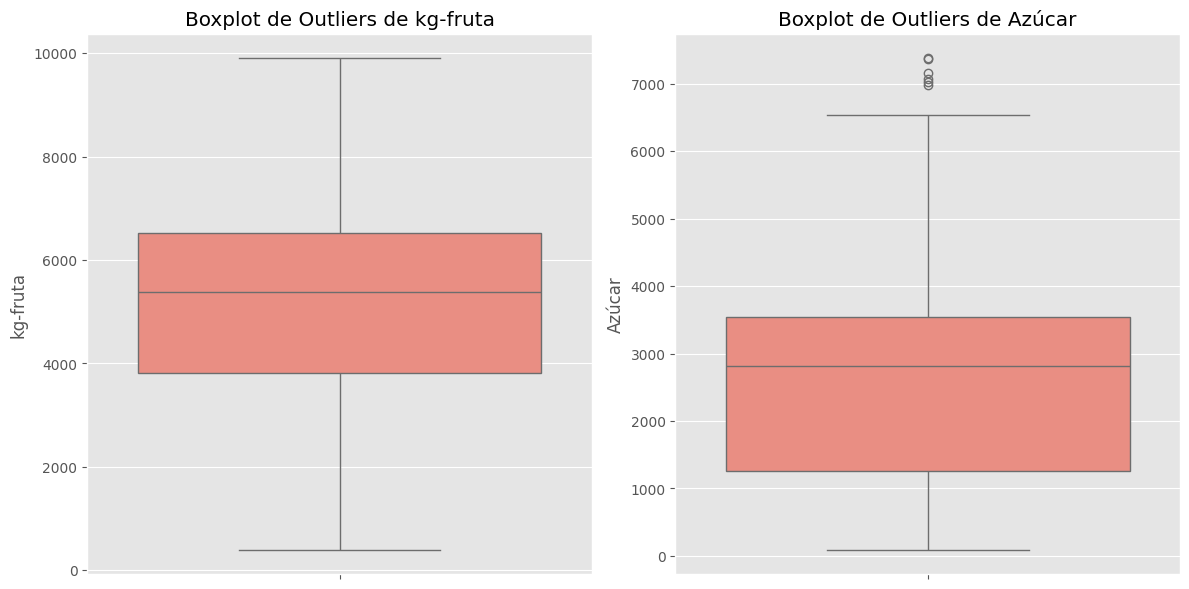

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest

# Supongamos que 'data' es tu DataFrame original y ya está cargado.
# Asegúrate de tener las columnas 'kg-fruta' y 'azucar'.

# Seleccionar las columnas relevantes
X = data[['kg-fruta', 'azucar']]

# Inicializar y ajustar el modelo Isolation Forest
isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)

# Agregar la predicción de outliers al DataFrame
data['outlier'] = outlier_pred

# Cambiar el valor de -1 a True (outlier) y 1 a False (inlier)
data['outlier'] = data['outlier'].map({-1: True, 1: False})

# Filtrar solo los outliers
outliers_data = data[data['outlier'] == True]

# Visualizar los outliers en un boxplot
plt.figure(figsize=(12, 6))

# Boxplot para 'kg-fruta'
plt.subplot(1, 2, 1)
sns.boxplot(y=outliers_data['kg-fruta'], palette=["salmon"])
plt.title('Boxplot de Outliers de kg-fruta')
plt.ylabel('kg-fruta')

# Boxplot para 'azucar'
plt.subplot(1, 2, 2)
sns.boxplot(y=outliers_data['azucar'], palette=["salmon"])
plt.title('Boxplot de Outliers de Azúcar')
plt.ylabel('Azúcar')

# Mostrar los gráficos
plt.tight_layout()
plt.show()


Si se quieren eliminar los outliers se puede usar:

In [30]:
data = data.iloc[outlier_pred == 1]
data_labels = data_labels.iloc[outlier_pred == 1]

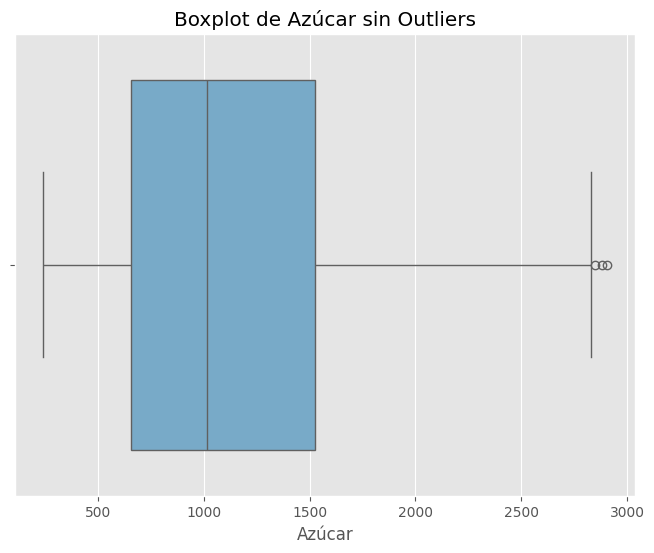

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supongamos que 'data' es tu DataFrame limpio sin outliers.

# Graficar Boxplot para 'azucar' después de eliminar outliers
plt.figure(figsize=(8, 6))

# Usar una paleta válida, por ejemplo, 'Blues' de Seaborn
sns.boxplot(x=data['azucar'], palette='Blues')
plt.title('Boxplot de Azúcar sin Outliers')
plt.xlabel('Azúcar')

# Mostrar el gráfico
plt.show()


### Transformación y Normalización

En la estandarización: primero se sustrae el valor medio (de manera que los  valores normalizados siempre tienen una media de cero) y luego se divide el resultado por la  desviación estándar (así que los valores normalizados tienen una desviación estándar igual a 1). A diferencia del escalado mín./máx., la estandarización no limita los valores a un rango  específico.  

$X_{\text{standardized}} = \frac{X - \mu}{\sigma}$
- **X** es el valor original del atributo.
- **μ** es la media de la característica.
- **σ** es la desviación estándar de la característica.
  
Scikit-Learn ofrece un transformador llamado `StandardScaler` para la estandarización: 

Aplicamos una transformación logarítmica a los datos para corregir la distribución. Esta transformación es especialmente útil porque los datos tienen una cola pesada hacia la derecha (sesgo positivo).

In [11]:
# Transformación logaritmica

data['kg-fruta'] = np.log(data['kg-fruta'] + 1)  # +1 para evitar log(0)
data['azucar'] = np.log(data['azucar'] + 1)  # +1 para evitar log(0)


In [12]:
from sklearn.preprocessing import StandardScaler

# Normalización

std_scaler = StandardScaler()
data[['kg-fruta', 'azucar']] = std_scaler.fit_transform(data[['kg-fruta', 'azucar']])

print(data[['kg-fruta', 'azucar']].head())


       kg-fruta    azucar
1998   0.586372  0.082467
10022  0.031770  0.214984
10785 -0.354837  0.040898
415   -0.070391 -0.204908
11044  1.495061  1.826459


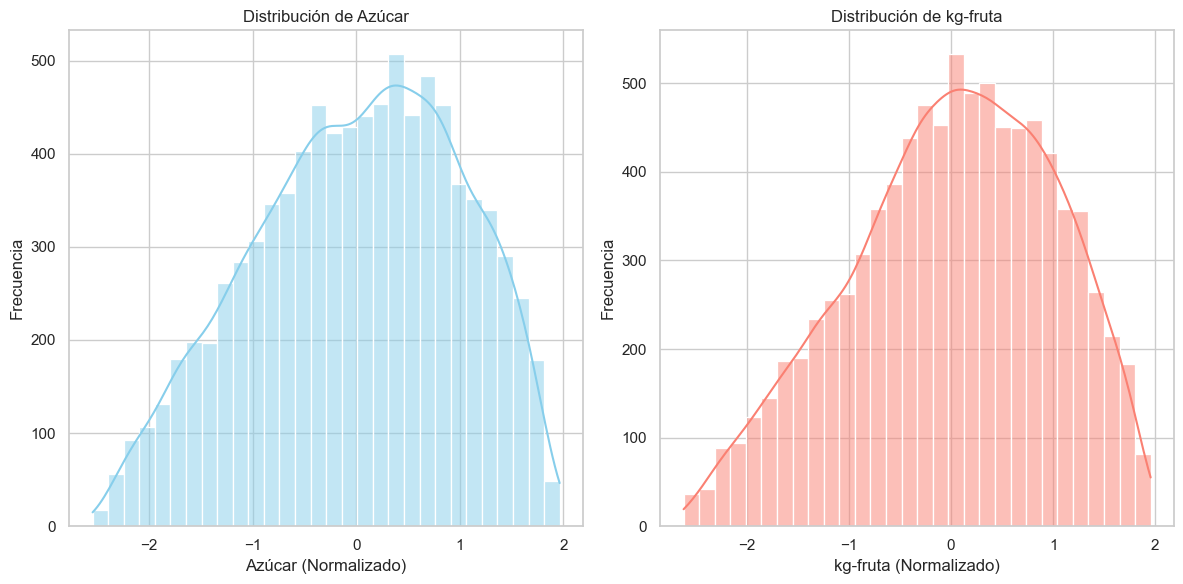

In [298]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que 'data' es tu DataFrame original y ya ha sido normalizado

# Establecer el estilo de Seaborn
sns.set(style="whitegrid")

# Crear una figura
plt.figure(figsize=(12, 6))

# Gráfico de 'azucar'
plt.subplot(1, 2, 1)
sns.histplot(data['azucar'], kde=True, color='skyblue', bins=30)
plt.title('Distribución de Azúcar')
plt.xlabel('Azúcar (Normalizado)')
plt.ylabel('Frecuencia')

# Gráfico de 'kg-fruta'
plt.subplot(1, 2, 2)
sns.histplot(data['kg-fruta'], kde=True, color='salmon', bins=30)
plt.title('Distribución de kg-fruta')
plt.xlabel('kg-fruta (Normalizado)')
plt.ylabel('Frecuencia')

# Mostrar los gráficos
plt.tight_layout()
plt.show()


Hasta ahora, nos hemos fijado en las `características de entrada`(predictores), pero puede que también  sea necesario transformar los valores objetivo (target). Por ejemplo, si la distribución objetivo es de  cola pesada, puedes elegir sustituir el objetivo por su logaritmo. Pero, si lo haces, el modelo de  regresión predecirá el **logaritmo de los kilogramos de mermelada a producir**. Necesitarás calcular el exponencial de la predicción del modelo si quieres el valor de los kilogramos de mermelada a producir.  Por suerte, la mayoría de los transformadores de Scikit-Learn tienen un método `inverse_  transform()`, lo que hace que sea fácil calcular la inversa de sus transformaciones.   

Por ejemplo,  el siguiente código de ejemplo muestra cómo escalar las etiquetas utilizando `StandardScaler` (como se hizo con las predictoras) y, después, entrenar un modelo simple de regresión lineal  en las etiquetas escaladas resultantes y utilizarlo para hacer predicciones con datos nuevos,  que transformamos de vuelta a la escala original utilizando el método `inverse_transform()` del escalador entrenado. Fíjate en que convertimos las etiquetas desde Series de Pandas a  DataFrame, ya que StandardScaler espera entradas 2D. Además, en este ejemplo entrenamos  solo el modelo en una sola característica de entradas (median income), por simplicidad.. . . 

**Paso 1**: Escalar los valores objetivo: Se utiliza StandardScaler para escalar las etiquetas (kg-mermelada) de forma similar a como se hizo con las características de entrada.

In [299]:
from sklearn.linear_model import LinearRegression
target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(data_labels.to_frame())
# Aquí, los valores objetivo data_labels se transforman con StandardScaler,
# ajustando los valores a una media de 0 y una desviación estándar de 1.

**Paso 2**. Entrenar el modelo con los valores escalados: Se entrena un modelo de regresión lineal  y hacer predicciones y revertir la transformación: Después de entrenar el modelo, se utilizan nuevos datos para hacer predicciones. Como las etiquetas fueron escaladas, las predicciones también estarán en la escala escalada. Para obtener los valores originales, es necesario invertir la transformación.

### Entrenando con 'kg-fruta' y 'azucar'

In [300]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Asumiendo que train_set ya está definido y contiene las columnas necesarias
data = train_set.drop("kg-mermelada", axis=1)
data_labels = train_set["kg-mermelada"].copy()

# Escalar las etiquetas si es necesario (solo si realmente lo necesitas)
scaler = StandardScaler()
scaled_labels = scaler.fit_transform(data_labels.values.reshape(-1, 1))

# Crear el modelo y entrenarlo con ambas características
model = LinearRegression()
model.fit(data[["kg-fruta", "azucar"]], scaled_labels)

# Seleccionar nuevos datos para predecir
nuevos_datos = data[["kg-fruta", "azucar"]].iloc[:5]

# Hacer las predicciones
prediccion_scaled = model.predict(nuevos_datos)

# Si escalaste las etiquetas, desescala las predicciones
prediccion = scaler.inverse_transform(prediccion_scaled)

# Imprimir las predicciones
print(prediccion)


[[1295.23300226]
 [2853.21888613]
 [2231.44806041]
 [2272.37193291]
 [1568.11440281]]


### Entrenamos con las caracteristicas de forma independiente.

In [242]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Asumiendo que train_set ya está definido y contiene las columnas necesarias
data = train_set.drop("kg-mermelada", axis=1)
data_labels = train_set["kg-mermelada"].copy()

# Escalar las etiquetas
scaler = StandardScaler()
scaled_labels = scaler.fit_transform(data_labels.values.reshape(-1, 1))


### Entrenando con 'kg-fruta'

In [243]:
# ** Modelo para kg-fruta **
model_fruta = LinearRegression()
model_fruta.fit(data[["kg-fruta"]], scaled_labels)

# Seleccionar nuevos datos para predecir con 'kg-fruta'
nuevos_datos_fruta = data[["kg-fruta"]].iloc[:5]

# Hacer las predicciones
prediccion_fruta_scaled = model_fruta.predict(nuevos_datos_fruta)

# Desescalar las predicciones
prediccion_fruta = scaler.inverse_transform(prediccion_fruta_scaled)

# Imprimir las predicciones para kg-fruta
print("Predicciones para kg-fruta:")
print(prediccion_fruta)

Predicciones para kg-fruta:
[[1947.56201973]
 [3074.31403147]
 [2321.26595064]
 [2051.78477656]
 [2049.48623569]]


### Entrenando con 'azucar'

In [244]:
# ** Modelo para azucar **
model_azucar = LinearRegression()
model_azucar.fit(data[["azucar"]], scaled_labels)

# Seleccionar nuevos datos para predecir con 'azucar'
nuevos_datos_azucar = data[["azucar"]].iloc[:5]

# Hacer las predicciones
prediccion_azucar_scaled = model_azucar.predict(nuevos_datos_azucar)

# Desescalar las predicciones
prediccion_azucar = scaler.inverse_transform(prediccion_azucar_scaled)

# Imprimir las predicciones para azucar
print("Predicciones para azucar:")

print(prediccion_azucar)

Predicciones para azucar:
[[1831.6096161 ]
 [3310.0283495 ]
 [2931.28297694]
 [1787.03664398]
 [2674.32732917]]


### **Forma mas simple**.  
Scikit-Learn proporciona el modelo `TransformedTargetRegressor`, que automatiza tanto la transformación como la inversión de la escala en los valores objetivo.  

El TransformedTargetRegressor se encarga de:  

- Transformar las etiquetas antes de entrenar el modelo.  
- Entrenar el modelo con las etiquetas escaladas.  
- Invertir la transformación automáticamente cuando se hacen predicciones, de modo que se devuelvan los valores en la escala original.  

In [245]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
model.fit(data[["azucar"]], data_labels)
predictions = model.predict(nuevos_datos_azucar)

In [222]:
predictions

array([1831.6096161 , 3310.0283495 , 2931.28297694, 1787.03664398,
       2674.32732917])

## ENTRENANDO ALGORITMOS DE MACHINE LEARNING

### Regresión Multiple

In [268]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

P = []  # Lista global para almacenar los nuevos datos de predicción

def predice(lista, data, data_labels):
    # Inicializar el escalador
    scaler = StandardScaler()
    # Filtrar solo las columnas numéricas relevantes para escalar
    data_predictoras = data[['kg-fruta', 'azucar']]
    # Escalar los datos
    data_scaled = scaler.fit_transform(data_predictoras) 
    # Obtener las etiquetas
    y = data_labels.values.flatten()  
    # Inicializar el modelo de regresión lineal
    modelo = linear_model.LinearRegression()
    # Ajustar el modelo a los datos escalados
    modelo.fit(data_scaled, y)
    y_pred= modelo.predict(data_scaled)
    # Calcular métricas
    r_squared = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    # Mostrando las métricas
    print(f"R-squared= {r_squared:.3f}")
    print(f"MSE= {mse:.3f}")
    print(f"MAE= {mae:.3f}\n")
    # Añadir los nuevos datos (la lista que recibe la función) a P
    P.append(lista)
    # Escalar los nuevos datos
    nuevos_datos_escalado = scaler.transform([lista])  # Debe ser una lista de listas para la predicción
    # Hacer la predicción
    prediccion = modelo.predict(nuevos_datos_escalado)
  
    return prediccion


print("ESTIMACION DE MERMELADA A PRODUCIR EN FUNCION DE LA CANTIDAD DE MATERIA PRIMA Y AZUCAR\n")
print()
fruta= input("Kg de fruta: ")
azucar= input("kg de azúcar: ")

print(f"Se estima una producción de Mermelada de: {predice([fruta, azucar], data, data_labels).round(3)}kg.")


ESTIMACION DE DE MERMELADA A PRODUCIR EN FUNCION DE LA CANTIDAD DE MATERIA PRIMA Y AZUCAR


R-squared= 0.825
MSE= 251607.951
MAE= 402.390

Se estima una producción de Mermelada de: [3677.245]kg.


### Maquina de Soporte Vectorial

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Filtrar solo columnas numéricas
data_numeric = data.select_dtypes(include=['number'])

# Si necesitas las etiquetas (target), asegúrate de que estén alineadas
X_train, X_test, y_train, y_test = train_test_split(data_numeric, data_labels, test_size=0.2, random_state=42)

# Selecciona solo las características de interés
features_of_interest = ['kg-fruta', 'azucar']  # Agrega más características si es necesario
data_selected = data[features_of_interest]

# Asegúrate de que las etiquetas (target) sean las correctas
X_train, X_test, y_train, y_test = train_test_split(data_selected, data_labels, test_size=0.2, random_state=42)

# Entrenar el modelo
regressor = SVR(kernel='linear')
regressor.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = regressor.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print("MSE:", mse)
print("MAE:", mae)
print("R-squared:", r_squared)
